# Clustering of dataset consisting of data with vastly different dimensionality

Author: Rachel Sgallova

Contact: rachel.sgallova@centrum.cz

## Data sources

All data used in this analysis come from research performed during my PhD studies. These results were published in various places, listed below with the exact location of each dataset.

### 1. Biochemical activities and DNA sequences
- **File name**: 'activities'
- **Paper**: Volek, Martin, et al. "Overlapping but distinct: a new model for G-quadruplex biochemical specificity." *Nucleic acids research* 49.4 (2021): 1816-1827.
- **Location in the paper**: Supplementary Table S3
- **Content**: Five biochemical activities and DNA sequences of analyzed samples
- **Note**: Sequence names follow the convention used in my dissertation thesis. The conversions to the names in the paper are provided in the Supplementary Table A3 of my thesis. The sequence order is identical in both sources.

### 2. NMR spectra and metadata
- **Directory name**: 'spectra_of_all_sequences'
- **Paper**: Sgallová, Ráchel, et al. "NMR Screen Reveals the Diverse Structural Landscape of a G‐Quadruplex Library." *Chemistry–A European Journal* 30.67 (2024): e202401437
- **Location in the paper**: online repository referenced in the Supplementary Information.
- **Note**: This directory contains a subdirectory 'NMR_spectra' with spectral folders and the Excel file NMR_spectra_list.xlsx containing metadata, such as sample names and DNA sequences. This Excel file was used in this analysis to import metadata.

### 3. Previously published Classes
- **Source**: Table S4 of NMR Screen... (full reference above)
- **Note**: Used to compare results of this study with published results.
- **Additional figures**: Figures 3.26 and A.1 from my dissertation.

### Links to all sources
- *Overlapping but distinct...*: https://doi.org/10.1093/nar/gkab037 (valid 9.8.2025)
- *NMR Screen...*: https://doi.org/10.1002/chem.202401437 (valid 9.8.2025)
- Dissertation thesis: https://dspace.cuni.cz/handle/20.500.11956/197989 (valid 9.8.2025)
- NMR spectra in online repository: https://doi.org/10.5281/zenodo.13838248 (valid 9.8.2025)

## Introduction

My dissertation thesis was focused on G-quadruplexes - noncanonical nucleic acid structures formed by stacked guanine tetrads. We worked with a library of 496 variants of a reference G-quadruplex. In studies prior to my dissertation, all sequences from this library were characterized for their ability to bind GTP, promote a model peroxidase reaction, generate intrinsic fluorescence, and to form multimers. During my PhD studies, we determined the 1H NMR spectrum of each sequence and statistically analyzed the whole dataset. We identified classes, that differ both in their spectral properties and in their biochemical properties.

A key challenge with this dataset is the difference in scale: each NMR spectrum consist of hundreds of values for each sequence, while the biochemical activities are just five numbers per sequence. Because of this imbalance, the two types of data were previously analyzed separately to prevent the NMR data from dominating the analysis.

In this study, I will first reduce the dimensionality of the NMR spectra using PCA, then merge them with the biochemical and sequence variables. I will perform clustering with HDBSCAN and compare the results to those from my dissertation.

The purpose of this work is not to produce a publication-level biophysical study, but to demonstrate a proof of concept: that datasets of vastly different dimensionality can be integrated and jointly analyzed, using a well-studied dataset with existing clustering results as a test case.

In [1]:
# No import is performed bellow this cell
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy #Necessary for nmrglue
import nmrglue as ng #Reference bellow in the description of function process_NMR_spectra 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import hdbscan
from PyPDF2 import PdfReader
from pdf2image import convert_from_path

### Figures graphically describing previous results

These figures will be used to compare the results of this analysis with previously published results to evaluate whether the proposed approach is valid.

#### Key observations from the figures
(These points also become evident during exploratory data analysis, as they are prominent upon closer inspection of the dataset): 
- The dataset contains a substantial proportion of noise. Specifically, the Class 'no G4 signals' formed out of sequences with no activities and no signals in NMR spectrum, represents more than 1/4 of the whole dataset.
- Some classes differ significantly from each other, while some do not.
- Class sizes vary significantly.

#### Library structure
All samples originate from a DNA mutational library comprising four sublibraries:
- Tetrad library
- 17.3 library
- 17.4 library
- 17.10 library

Each sublibrary is internally mutation-homogeneous: within a sublibrary, all allowed variants occur with equal probability. However, the combined library is not mutation-homogeneous. For example, there is only one sequence with the tetrad sequence GGGA, whereas there are 81 sequences with AGGG.

This uneven distribution means it is reasonable to conduct analyses both on the full library and on each sublibrary separately

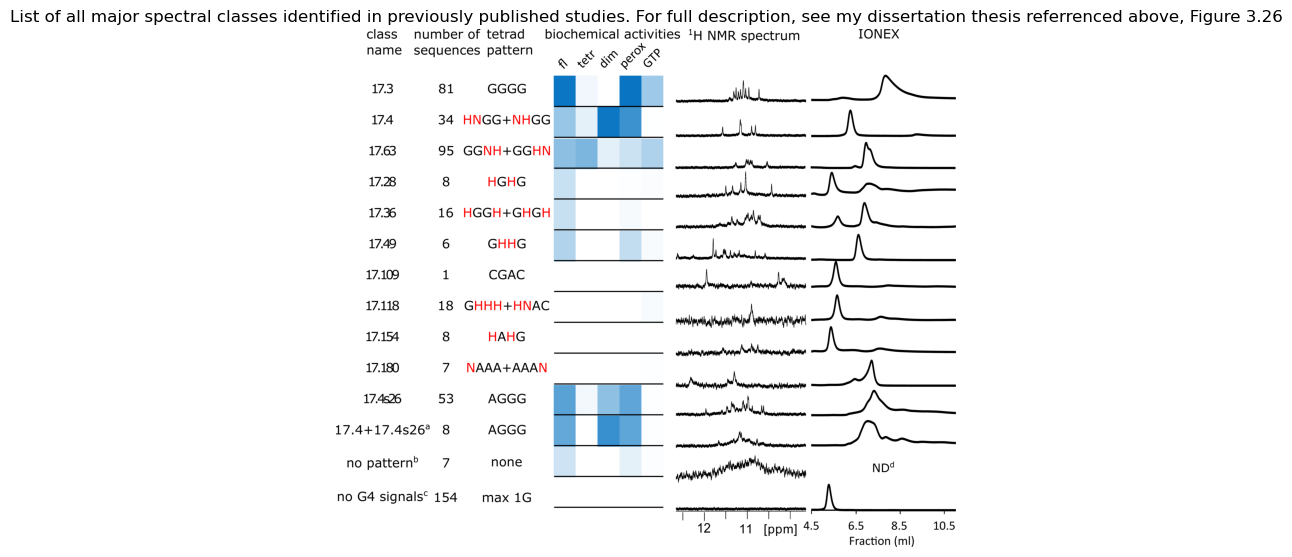

In [2]:
images = convert_from_path("classes_graphical.pdf", dpi=600)
fig = plt.figure(figsize=(8,8))
plt.imshow(images[0])
plt.axis("off")
plt.title('List of all major spectral classes identified in previously published studies. For full description, see my dissertation thesis referrenced above, Figure 3.26')
plt.show()

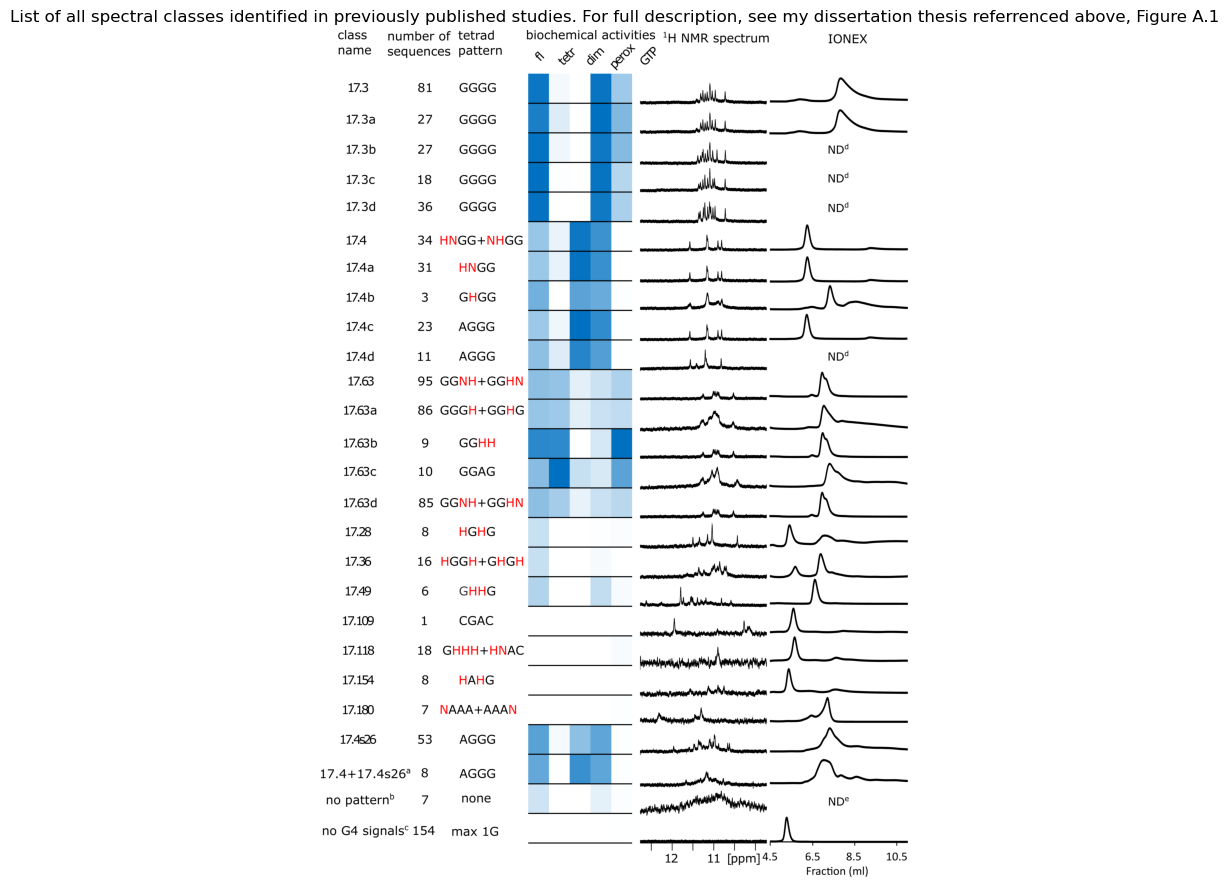

In [3]:
images = convert_from_path("classes_graphical_offspring_classes.pdf", dpi=600)
fig = plt.figure(figsize=(8,11))
plt.imshow(images[0])
plt.axis("off")
plt.title('List of all spectral classes identified in previously published studies. For full description, see my dissertation thesis referrenced above, Figure A.1')
plt.show()

## Functions used later for the analysis

### Function for importing and preprocesing of NMR data

For the data preparation for NMR spectra, I will use multiple steps:
- Import by Nmrglue
- Allignment of spectra (see notes in the code/help for the function for more details)
- Spectra trimming (not performed, if signal region limits are outside bounds of imported data)
- Normalization by MinMaxScaller, which is necessary for the dataset studied here, because some of them were obtained with different experimental conditions (specifically with different measuring time or sample concentration, which directly affects absolute intensity of the spectrum).

#### Detailed description of usage of nmrglue
For importing NMR spectra, I will use Nmrglue, reference: Helmus, Jonathan J., and Christopher P. Jaroniec. "Nmrglue: an open source Python package for the analysis of multidimensional NMR data." *Journal of biomolecular NMR* 55.4 (2013): 355-367.

For importing processed data in Bruker format, I will use ng.bruker.read_pdata. Then, I will use three steps to create the ppm scale: First is creation of universal dictionary by bruker.guess_udic() (https://nmrglue.readthedocs.io/en/latest/tutorial.html). It contains amongst other variables:
- sw: spectral width in Hz
- obs: resonance frequency for the observed nucleus
- label: 1H - data were measured on hydrogen
- car: Carrier frequency in Hz (offset in Hz of the center of the spectral window)
- size: number of spectral points
- time: True for time domain (for all data processed in this notebook)

Second step is creating a units conversion objects from universal dictionary using information mentioned above by fileiobase.uc_from_udic(dictionary,axis_number) (https://nmrglue.readthedocs.io/en/latest/reference/generated/nmrglue.fileio.fileiobase.uc_from_udic.html). The final step is creating chemical shift axis by ppm_scale().

In [4]:
def process_NMR_spectra (NMR_data_dir,metadata_file,signal_region_min,signal_region_max):
    '''This function takes a folder with processed NMR data (path to this folder is in the variable NMR_data_dir), second parameter is an excel file
    (resp. path to this file) with a single sheet with column 'new number' containing numbers of NMR spectra. Then, data from all numbers x from 
    column 'nem number' from the metadata file from path spectra_of_all_sequences/NMR_spectra/{x}/pdata/1 are imported by nmrglue 
    and chemical shift axis is calculated by nmrglue also.
    All spectra are then alligned to start at the same maximal chemical shift (within error of a step between two measured spectral points).
    Spectra are trimmed to contain only shifts within user defined signal region and normalized by the MinMaxScaler.
    It returns a dataframe with processed spectra.'''
    #Importing metadata
    metadata=pd.read_excel(metadata_file)[['new number']]
    spectral_numbers=metadata['new number']

    #Importing NMR spectra
    spectra={}
    shifts={}
    for x in spectral_numbers:
        #Importing NMR data for spectrum number x
        #dic,data = ng.bruker.read_pdata(f'spectra_of_all_sequences/NMR_spectra/{x}/pdata/1')
        dic,data = ng.bruker.read_pdata(f'{NMR_data_dir}/{x}/pdata/1')
        
        #Calculating chemical shift axis in three steps:
        #Creating universal dictionary
        universal_dictionary = ng.bruker.guess_udic(dic, data)
        #Creating unit conversion object
        unit_conversion = ng.fileiobase.uc_from_udic(universal_dictionary, 0)
        #Creating chemical shift axis
        ppm_scale = unit_conversion.ppm_scale()

        spectra[str(x)]=data
        shifts[str(x)]=ppm_scale
    
    df_spectra = pd.DataFrame(spectra)
    df_shifts = pd.DataFrame(shifts)
    #I want all chemical shift axis to start at the same number, the first row of df_shifts contains maximum for all chemical shifts axis,
    #so I will calculate minimum in the first row of this dataframe, determine position of value in each column, which is the closest to this minimum,
    #and shift each column of the df_spectra by the calculated number of positions in negative direction. 
    #This will create a fixed df_spectra, where all spectra begin at the same chemical shift.
    #Then, I will append to the dataframe with fixed spectra a chemical shift of the column, which contains minimum in the df_shifts 
    #(the correct shift axis)
    df_shift_difference=(df_shifts-df_shifts.loc[0].min()).abs()
    min_positions=df_shift_difference.idxmin()

    df_spectra_fixed=pd.DataFrame()
    for col in df_spectra.columns:
        new_column=df_spectra[col].shift(-min_positions.get(col,1)).copy()
        df_spectra_fixed = pd.concat([df_spectra_fixed, new_column.rename(col)], axis=1)
    df_spectra_fixed.insert(0,'shift',df_shifts.loc[:,df_shifts.loc[0].idxmin()])
    
    #Before proceeding further, I need to check, if user imput values for signal region make sense, If not, trimming will not be performed
    min_shift=df_spectra_fixed['shift'].min()
    max_shift=df_spectra_fixed['shift'].max()
    #print (f'Shift region of provided data is {min_shift},{max_shift}')
    trimming=1
    if (signal_region_min>signal_region_max):
        print ('Order of bounds of signal region is switched, values will be switched.')
        signal_region_min,signal_region_max=signal_region_max,signal_region_min
    if (signal_region_min<min_shift or signal_region_max>max_shift):
        print ('Signal region is not within the spectral region of provided data. Trimming of spectra will not be performed.')
        trimming=0
        
    #Now, I will create a graph of all spectra to show signal region
    plt.figure(figsize=(10, 4))
    # Creating a list of all not-shift columns to plot all spectra at once
    y_columns = (df_spectra_fixed.columns.difference(['shift']))
    plt.plot(df_spectra_fixed['shift'], df_spectra_fixed[y_columns])
    # Inverting axis to show spectra consistently with NMR conventions
    plt.gca().invert_xaxis()
    plt.xlabel("Chemical Shift (ppm)")
    plt.ylabel("Intensity")
    plt.title("Plot of all raw spectra")
    plt.axvline(signal_region_min, linewidth=1,color='blue')
    plt.axvline(signal_region_max, linewidth=1,color='blue')
    print ('Blue lines show the signal region.')
    #y limits fitting this specific spectral set and spectral region of interest, for different datasets, it needs to be adjusted.
    plt.ylim(-1e4,2e5)
    plt.show()

    #Next step is trimming the spectra
    if (trimming==1):
        df_trimmed = df_spectra_fixed[df_spectra_fixed['shift'].between(signal_region_min, signal_region_max)].copy()
        plt.figure(figsize=(10, 4))
        y_columns = (df_trimmed.columns.difference(['shift']))
        plt.plot(df_trimmed['shift'], df_trimmed[y_columns])
        plt.gca().invert_xaxis()
        plt.xlabel("Chemical Shift (ppm)")
        plt.ylabel("Intensity")
        plt.title("Plot of all trimmed spectra")
        plt.show()
    if (trimming==0): df_trimmed=df_spectra_fixed.copy()
    #Normalization
    #It is necessary to normalize all the spectra, because, for the dataset, for which this algorithm was developed,
    #some of them were obtained with different experimental conditions 
    #(specifically with different measuring time or sample concentration, which directly affects absolute intensity of the spectrum).
    df_trimmed.columns = [str(x) for x in df_trimmed.columns]
    scaler = MinMaxScaler()
    scaler.fit(df_trimmed)
    df_normalized = scaler.transform(df_trimmed).copy()
    df_normalized = pd.DataFrame(df_normalized, index=df_trimmed.index, columns=df_trimmed.columns)
    plt.figure(figsize=(10, 4))
    y_columns = (df_normalized.columns.difference(['shift']))
    plt.plot(df_normalized['shift'], df_normalized[y_columns])
    plt.gca().invert_xaxis()
    plt.xlabel("Chemical Shift (ppm)")
    plt.ylabel("Intensity")
    plt.title("Plot of all normalized spectra")
    plt.show()
    print ('Note: the figure looks the way it does, because of the normalization - every spectrum has a maximum at 1.')

    return df_normalized

### Function for importing and procesing metadata

I need to create a dataframe with metadata - sample names, library sections they belong to, and DNA sequences of all samples. Out of DNA sequence, only positions with variable nucleotides will be stored - positions 2, 6, 11, and 15 forming the middle tetrad of the reference G-quadruplex 17.3 and positions 4, 8, 9, and 13 forming loops of the same structure. The remaining ones are the same for al sequences, so retaining them would be useless.

In [5]:
def process_metadata(metadata_file):
    '''This function imports metadata from an excel file with a single sheet and this sheet must contain columns 'sample name' and 'DNA sequence'.
    From column sample name, it identifies to which sublibrary each sequence belongs (alternativly, this information can be found in table A.12 in 
    my dissertation, which is refferences at the beginning of this document).
    From column 'DNA sequence' it extracts information about 8 variable sequence positions into individual columns.
    Finaly, it returns a dataframe with processed metadata.'''
    metadata=pd.read_excel(metadata_file, index_col=None, header=0)[['sample name','DNA sequence']]
    print ('Imported metadata:')
    print(metadata.head())
    
    #Now, I will extract relevant sequence positions
    metadata['position 2']=metadata['DNA sequence'].str[1]
    metadata['position 6']=metadata['DNA sequence'].str[5]
    metadata['position 11']=metadata['DNA sequence'].str[10]
    metadata['position 15']=metadata['DNA sequence'].str[14]
    metadata['position 4']=metadata['DNA sequence'].str[3]
    metadata['position 8']=metadata['DNA sequence'].str[7]
    metadata['position 9']=metadata['DNA sequence'].str[8]
    metadata['position 13']=metadata['DNA sequence'].str[12]

    #Now, I will determine from sample names the sublibraries (naming conventions are explained in detail in my dissertation thesis)
    def determine_library(sample_name):
        if ('A' in sample_name or 'C' in sample_name or 'T' in sample_name or 's' in sample_name): #This sample belongs into one of the loop libraries
            if '17.3' in sample_name:
                return 3
            elif '17.4' in sample_name:
                return 4
            elif '17.10' in sample_name:
                return 10
        else: #Carefull: this returns 1 even for sequences 17.3, 17.4, and 17.10, which belong into two libraries at once.
                return 1
    metadata.rename(columns={'sample name': 'sample_name'}, inplace=True)
    metadata['library']=metadata['sample_name'].map(determine_library)
    
    #Now, I will create binary columns for each library
    mappings_tetrad_lib = {1:1,3:0,4:0,10:0}
    mappings_17_3_lib = {1:0,3:1,4:0,10:0}
    mappings_17_4_lib = {1:0,3:0,4:1,10:0}
    mappings_17_10_lib = {1:0,3:0,4:0,10:1}
    metadata['tetrad_lib']=metadata['library'].map(mappings_tetrad_lib)
    metadata['17_3_lib']=metadata['library'].map(mappings_17_3_lib)
    metadata['17_4_lib']=metadata['library'].map(mappings_17_4_lib)
    metadata['17_10_lib']=metadata['library'].map(mappings_17_10_lib)

    #Corrections for the three samples, that belong into two libraries
    metadata.loc[metadata['sample_name']=='17.3','17_3_lib']=1
    metadata.loc[metadata['sample_name']=='17.4','17_4_lib']=1
    metadata.loc[metadata['sample_name']=='17.10','17_10_lib']=1

    #Finally, I will drom columns, which are no longer needed
    metadata=metadata.drop('DNA sequence', axis=1)
    metadata=metadata.drop('library', axis=1)
    print ('Processed metadata:')
    print(metadata.head())
    return metadata

### Function for transforming metadata

Part of metadata information needs to be included in the clustering analysis - the sequence information. Metadata columns such as 'Position 2' will be translated into numerical variables by one-hot encoding. This will allow using them in analysis by HDBSCAN, because distances calculated between different samples based on one-hot-encoded DNA sequence will make reasonale sense (at least as much sense as distances calculated based on combination of various biochemical activities).

In [6]:
def create_sequence_variables (metadata):
    '''This function takes output dataframe from function process_metadata and transforms all categorical columns except 'sample_name'
    by one-hot encoding and then outputs a dataframe with only these columns and sample_name'''
    
    categorical_columns=metadata.select_dtypes(include=['object']).columns.tolist()
    categorical_columns.remove('sample_name')
    
    encoder = OneHotEncoder(sparse_output=False)
    sequence_one_hot_encoded = encoder.fit_transform(metadata[categorical_columns])
    sequence_variables = pd.DataFrame(sequence_one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
    sequence_variables = pd.concat([metadata['sample_name'],sequence_variables],axis=1)
    
    return sequence_variables

### Function for performing PCA analysis

In [7]:
def perform_PCA (data,number_PCs):
    '''This function recieves already normalized datased in a dataframe and performs PCA analyzis of transposed dataset either without 
    limiting number of principal components (when parameter number_PCs is set to 0 or smaller number), or with a a limited number of components
    (using parameter number_PCs as the number of components).
    It also calculates the numbers of components explaining 70 and 90% of variance of the whole dataset (if enough variance is explained 
    by the used number of components), since the 70 to 90% interval is usually used to determine the cutoff for the number of principal components.
    Finally, it returns transformed data, explained variance by each principal component and principal components.
    '''
    #Firstly, I will perform PCA and transform data
    if (number_PCs<=0):
        pca=PCA()
    else: pca=PCA(n_components=number_PCs)
    data_T=data.T.copy()
    data_T.columns=data_T.columns.astype(str)
    pca.fit(data_T)
    variances=pca.explained_variance_ratio_
    components = pca.components_
    data_transformed=pd.DataFrame(pca.transform(data_T))

    #Now, I will plot figure of explained variances by each principal component
    fig = plt.figure(figsize=(2.5,2))
    plt.scatter(pd.Series(np.arange(1,len(variances)+1,1)),100*variances)
    plt.xlabel('Principal component number')
    plt.ylabel('Explained variance (%)')
    plt.title('Explained variance by each principal component')
    plt.show()

    #Now, I want to calculate, how many principal components explain 70 and 90% of variance 
    #(if enough variance is explained by the used number of components)
    i = 1
    min_limit_found = 0
    max_limit_found = 0
    while (i<=len(variances)):
        variance_sum=variances[:i].sum()
        if (min_limit_found==0):
            if variance_sum>=0.7:
                min_limit=i
                min_limit_found=1
                print(f'The first {i} principal components explain {variance_sum*100:.2f}% variance.')
        if (max_limit_found==0):
            if variance_sum>=0.9:
                max_limit=i
                max_limit_found=1
                print(f'The first {i} principal components explain {variance_sum*100:.2f}% variance.')
        i+=1
    if (number_PCs>0):
        variance_sum=variances.sum()
        print (f'All principal components used for this analysis ({number_PCs} components) together explain {variance_sum*100:.2f}% variance.')

    #Finally, time to return transformed data, explained variance by each principal component and principal components
    return (data_transformed, variances, components)

### Function for filtering data about single library

In [8]:
def library_filtering (library,df):
    '''This function gets a single dataframe column with a binary values indicating which samples belong into analyzed library and 
    a dataframe, which should be filtered to contain only rows corresponding to given library.
    '''
    library_df=library.to_frame('library')
    filtered_df=df.copy()
    #Dataframe with NMR spectra have different indexes than 0 to n, so this way, indexes will align
    library_df.index=filtered_df.index
    filtered_df['library']=library_df['library']
    filtered_df=filtered_df[filtered_df['library']==1]
    filtered_df=filtered_df.drop('library',axis=1)
    #I will drop index of the resulting df, because I do not want it to cause problems later
    filtered_df=filtered_df.reset_index(drop=True)
    return filtered_df

### Function for performing clustering by HDBSCAN

In [9]:
def perform_clustering(df):
    '''This function standartizes provided data by standard scaller and clusters them by HDBSCAN.'''
    df.columns=df.columns.astype(str)
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled=pd.DataFrame(scaler.transform(df),columns=df.columns)
    hdb=hdbscan.HDBSCAN()
    clusters=hdb.fit_predict(df_scaled)
    return clusters

## Importing all data

Activities and a table with results from my dissertion do not need any processing, so I will not be creating functions for their import.

In [10]:
activities_file='activities.xlsx'
activities=pd.read_excel(activities_file, index_col=None, header=0)
activities=activities.drop('index',axis=1)
activities.head()

,sample name,fl,tetr,dim,perox,GTP
0,17.3,20.000,1.0,1.000,20.000,20.000
1,17.4,6.753,1.0,145.044,15.517,1.000
2,17.5,7.219,1.0,134.759,15.862,1.000
3,17.6,8.471,1.0,147.487,16.896,1.000
4,17.7,9.724,1.0,147.796,12.069,2.236


In [11]:
results_comparison_file='table_classes.xlsx'
results_comparison=pd.read_excel(results_comparison_file, index_col=None, header=0)[['Name','Class']]
results_comparison.head()

,Name,Class
0,17.3,"17.3, 17.3a"
1,17.4,"17.4, 17.4a, 17.4c"
2,17.5,"17.4, 17.4a, 17.4c"
3,17.6,"17.4, 17.4a, 17.4c"
4,17.7,"17.4, 17.4b, 17.4c"


In [12]:
metadata_file='spectra_of_all_sequences/NMR_spectra_list.xlsx'
metadata=process_metadata(metadata_file)

Imported metadata:
  sample name       DNA sequence
0        17.3  GGGTGGGAAGGGTGGGA
1        17.4  GAGTGGGAAGGGTGGGA
2        17.5  GCGTGGGAAGGGTGGGA
3        17.6  GTGTGGGAAGGGTGGGA
4        17.7  GGGTGAGAAGGGTGGGA
Processed metadata:
  sample_name position 2 position 6 position 11 position 15 position 4  \
0        17.3          G          G           G           G          T   
1        17.4          A          G           G           G          T   
2        17.5          C          G           G           G          T   
3        17.6          T          G           G           G          T   
4        17.7          G          A           G           G          T   

  position 8 position 9 position 13  tetrad_lib  17_3_lib  17_4_lib  17_10_lib  
0          A          A           T           1         1         0          0  
1          A          A           T           1         0         1          0  
2          A          A           T           1         0         0        

In [13]:
sequence_variables=create_sequence_variables(metadata)
sequence_variables.head()

,sample_name,position 2_A,position 2_C,position 2_G,position 2_T,position 6_A,position 6_C,position 6_G,position 6_T,position 11_A,...,position 4_T,position 8_A,position 8_C,position 8_T,position 9_A,position 9_C,position 9_T,position 13_A,position 13_C,position 13_T
0,17.3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,17.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,17.5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,17.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,17.7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Blue lines show the signal region.


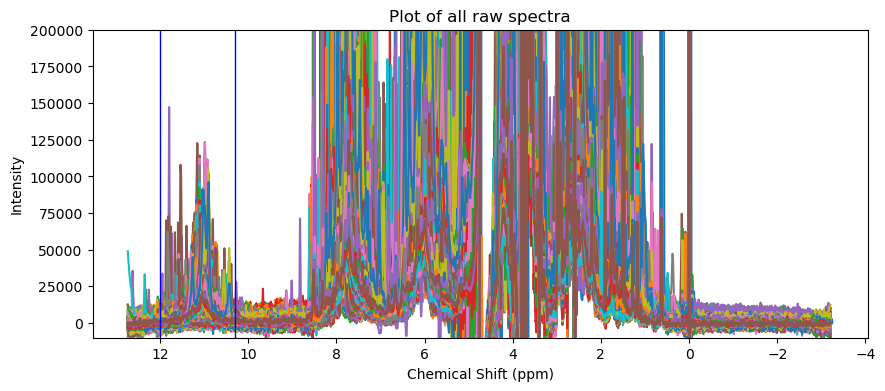

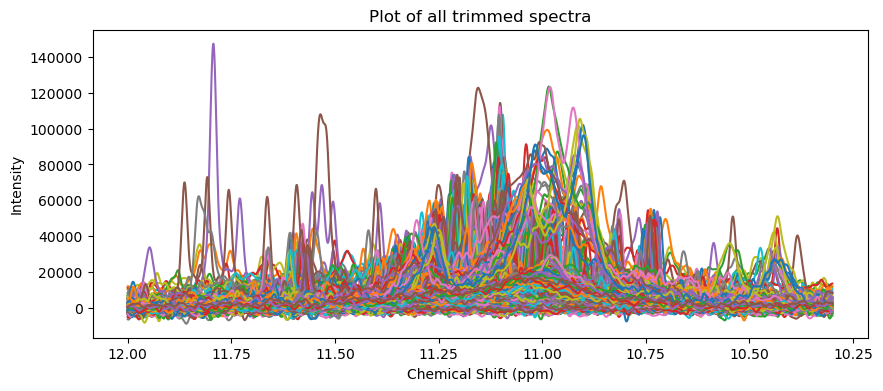

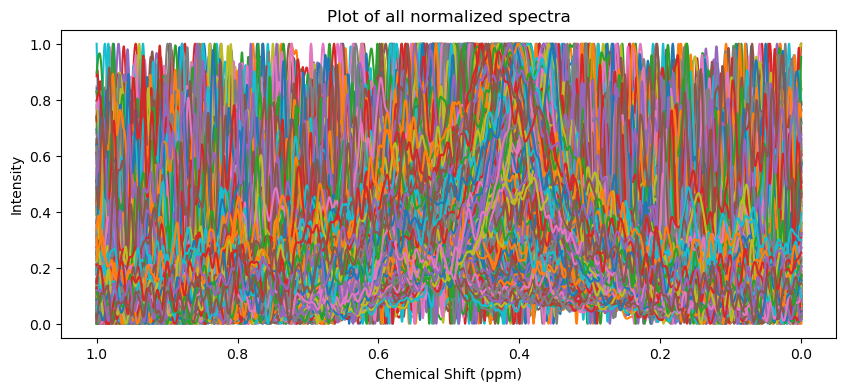

Note: the figure looks the way it does, because of the normalization - every spectrum has a maximum at 1.


In [14]:
spectra_processed=process_NMR_spectra('spectra_of_all_sequences/NMR_spectra','spectra_of_all_sequences/NMR_spectra_list.xlsx',10.3,12)

## Analyzing data

### Separating data based on libraries

I will analyze data as a whole set and when separated into individual libraries (tetrad library, 17.3 library, 17.4 library, and 17.10 library). To do that, I need to separate all data needed for analysis (NMR spectra, sequence variables, and activities) into subsets based on relevant columns in metadata. I will also separate into subsets the dataset with results for comparison.

Dataframe with NMR spectra has samples in columns, so when using function for filtering based on library, I need to transpose it back and forth

In [15]:
#For spectra for PCA, I need to drop the column with chemical shift and it comes handy for filtering based on libraries, so I will do it now
spectra_PCA=spectra_processed.copy()
spectra_PCA=spectra_PCA.drop('shift',axis=1)

In [16]:
#tetrad library
spectra_PCA_tetrad=library_filtering(metadata['tetrad_lib'],spectra_PCA.T).T.copy()
sequence_variables_tetrad=library_filtering(metadata['tetrad_lib'],sequence_variables).copy()
activities_tetrad=library_filtering(metadata['tetrad_lib'],activities).copy()
results_comparison_tetrad=library_filtering(metadata['tetrad_lib'],results_comparison).copy()

In [17]:
#17.3 library
spectra_PCA_17_3=library_filtering(metadata['17_3_lib'],spectra_PCA.T).T.copy()
sequence_variables_17_3=library_filtering(metadata['17_3_lib'],sequence_variables).copy()
activities_17_3=library_filtering(metadata['17_3_lib'],activities).copy()
results_comparison_17_3=library_filtering(metadata['17_3_lib'],results_comparison).copy()

In [18]:
#17.4 library
spectra_PCA_17_4=library_filtering(metadata['17_4_lib'],spectra_PCA.T).T.copy()
sequence_variables_17_4=library_filtering(metadata['17_4_lib'],sequence_variables).copy()
activities_17_4=library_filtering(metadata['17_4_lib'],activities).copy()
results_comparison_17_4=library_filtering(metadata['17_4_lib'],results_comparison).copy()

In [19]:
#17.10 library
spectra_PCA_17_10=library_filtering(metadata['17_10_lib'],spectra_PCA.T).T.copy()
sequence_variables_17_10=library_filtering(metadata['17_10_lib'],sequence_variables).copy()
activities_17_10=library_filtering(metadata['17_10_lib'],activities).copy()
results_comparison_17_10=library_filtering(metadata['17_10_lib'],results_comparison).copy()

### PCA of NMR spectra

Before I can analyze all data at once, I have to reduce dimensionality of NMR spectra. I will use PCA for that. Firstly, I will perform PCA without limiting number of principal components and I will look at explained variances and determine reasonable number of principal componets to use. For the purpose of this POC, I will try two numbers for each studied dataset, however, for any analysis beyond POC, further optimization would be necessary.

#### Whole dataset

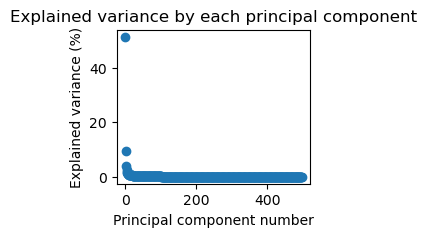

The first 6 principal components explain 70.22% variance.
The first 53 principal components explain 90.15% variance.


In [20]:
#PCA without limiting the number of principal components
(spectra_transformed_0,variances_0,components_0)=[x.copy() for x in perform_PCA(spectra_PCA,0)]

In [21]:
variances_0[:53]

array([0.51344754, 0.0937873 , 0.04047842, 0.02453986, 0.017866  ,
       0.01209832, 0.01132292, 0.01061429, 0.00878355, 0.0077563 ,
       0.00749739, 0.00670621, 0.00570938, 0.00543747, 0.00537862,
       0.00513422, 0.00490544, 0.00485793, 0.00480123, 0.00458121,
       0.00442425, 0.00437961, 0.00427877, 0.00411225, 0.00407188,
       0.00398342, 0.00386837, 0.00377144, 0.00368151, 0.00355213,
       0.00348639, 0.0034678 , 0.00339445, 0.0033526 , 0.00327444,
       0.00322169, 0.00317429, 0.00312957, 0.00298661, 0.00294108,
       0.00288347, 0.00283043, 0.00278829, 0.00276156, 0.00263853,
       0.00255495, 0.00251293, 0.00247342, 0.00246178, 0.00240269,
       0.00236579, 0.00230991, 0.00224663])

53 principal components is definitely to much, because I want to create a dataset with NMR spectra and biochemical activities represented by a comparable number of variables. 6 seems as a very reasonable number, since that NMR spectra will be represented by a similar number of variables, as all the biochemical activities altogether. I will use two numbers, 6 and 20 and compare the results (20 is the top limit of what I consider reasonable to try).

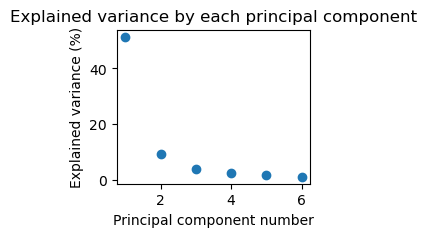

The first 6 principal components explain 70.22% variance.
All principal components used for this analysis (6 components) together explain 70.22% variance.


In [22]:
#PCA with 6 components
(spectra_transformed_6,variances_6,components_6)=[x.copy() for x in perform_PCA(spectra_PCA,6)]

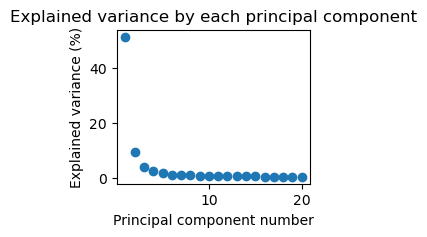

The first 6 principal components explain 70.22% variance.
All principal components used for this analysis (20 components) together explain 79.55% variance.


In [23]:
#PCA with 20 components
(spectra_transformed_20,variances_20,components_20)=[x.copy() for x in perform_PCA(spectra_PCA,20)]

#### Tetrad dataset

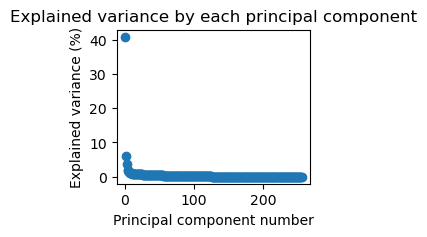

The first 24 principal components explain 70.64% variance.
The first 69 principal components explain 90.17% variance.


In [24]:
#PCA without limiting the number of principal components
(spectra_transformed_tetrad_0,variances_tetrad_0,components_tetrad_0)=[x.copy() for x in perform_PCA(spectra_PCA_tetrad,0)]

In [25]:
variances_tetrad_0[:69]

array([0.40891839, 0.05944921, 0.03769781, 0.01966374, 0.01529413,
       0.0132349 , 0.01182658, 0.0109195 , 0.010106  , 0.00950356,
       0.00913937, 0.00906656, 0.00866819, 0.00836761, 0.00805581,
       0.00797783, 0.00790376, 0.00780036, 0.00752362, 0.0073793 ,
       0.00724348, 0.00708106, 0.00688856, 0.00673994, 0.00651463,
       0.00644423, 0.00625197, 0.00618805, 0.00612111, 0.00605231,
       0.00590877, 0.00570157, 0.00559776, 0.0054867 , 0.00532417,
       0.00525359, 0.00509905, 0.00497511, 0.00487677, 0.00478478,
       0.00467451, 0.00461838, 0.00456086, 0.00449017, 0.00444124,
       0.00428783, 0.00418586, 0.00412553, 0.00402907, 0.00392703,
       0.00387688, 0.00384443, 0.00370327, 0.0036225 , 0.00360863,
       0.00349668, 0.00341217, 0.00331271, 0.00329037, 0.00320908,
       0.00311948, 0.00304512, 0.00300148, 0.0029389 , 0.00292099,
       0.00282708, 0.00275385, 0.0026967 , 0.00261399])

This result is quite surprising and I consider 24 principal components to be a too high number, so I will use as a first cut of limit the point, where explained variance by a single principal component goes below 1% - 9 principal components and then, I will increase the number of principal components to 20.

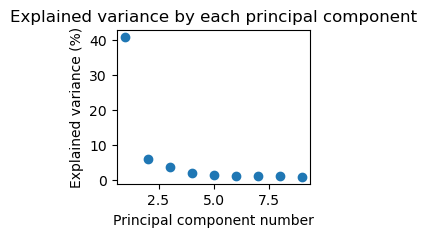

All principal components used for this analysis (9 components) together explain 58.71% variance.


In [26]:
#PCA with 9 components
(spectra_transformed_tetrad_9,variances_tetrad_0,components_tetrad_9)=[x.copy() for x in perform_PCA(spectra_PCA_tetrad,9)]

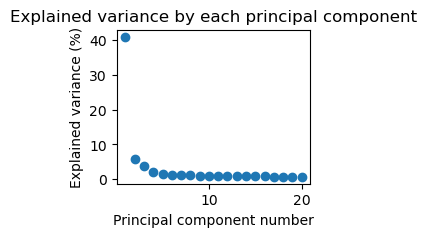

All principal components used for this analysis (20 components) together explain 67.83% variance.


In [27]:
# PCA with 20 components
(spectra_transformed_tetrad_20,variances_tetrad_20,components_tetrad_20)=[x.copy() for x in perform_PCA(spectra_PCA_tetrad,20)]

#### 17.3 loop library

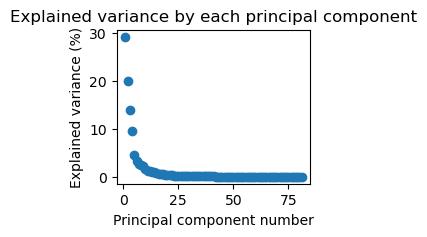

The first 4 principal components explain 72.73% variance.
The first 11 principal components explain 90.32% variance.


In [28]:
#PCA without limiting the number of principal components
(spectra_transformed_17_3_0,variances_17_3_0,components_17_3_0)=[x.copy() for x in perform_PCA(spectra_PCA_17_3,0)]

In [29]:
variances_17_3_0[:11]

array([0.29180176, 0.20008109, 0.1391531 , 0.09625007, 0.04440533,
       0.03309011, 0.02589883, 0.02382721, 0.02154904, 0.01515942,
       0.01202513])

For 17.3 library, only 11 componets are needed to explain 90% the variability of the whole dataset, so I will use them and I will also try using only 4 componets, which have significantly higher values than the rest and explain together over 70% of the variance.

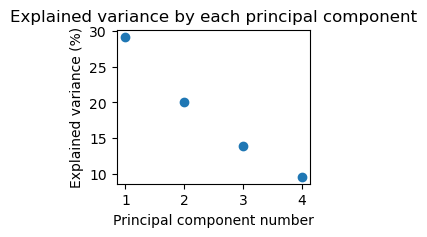

The first 4 principal components explain 72.73% variance.
All principal components used for this analysis (4 components) together explain 72.73% variance.


In [30]:
#PCA with 4 components
(spectra_transformed_17_3_4,variances_17_3_4,components_17_3_4)=[x.copy() for x in perform_PCA(spectra_PCA_17_3,4)]

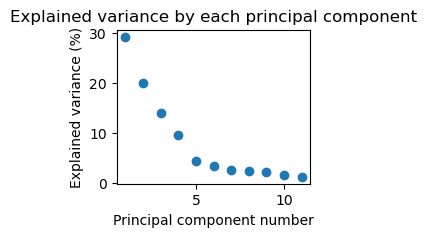

The first 4 principal components explain 72.73% variance.
The first 11 principal components explain 90.32% variance.
All principal components used for this analysis (11 components) together explain 90.32% variance.


In [31]:
#PCA with 11 components
(spectra_transformed_17_3_11,variances_17_3_11,components_17_3_11)=[x.copy() for x in perform_PCA(spectra_PCA_17_3,11)]

#### 17.4 loop library

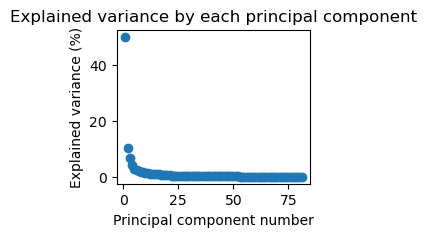

The first 4 principal components explain 71.43% variance.
The first 17 principal components explain 90.48% variance.


In [32]:
#PCA without limiting the number of principal components
(spectra_transformed_17_4_0,variances_17_4_0,components_17_4_0)=[x.copy() for x in perform_PCA(spectra_PCA_17_4,0)]

In [33]:
variances_17_4_0[:17]

array([0.502918  , 0.10222784, 0.06606688, 0.04311232, 0.02835763,
       0.02515433, 0.02165907, 0.01801182, 0.0158182 , 0.01414395,
       0.01317557, 0.01089972, 0.00972947, 0.00920394, 0.00909377,
       0.00823235, 0.00700992])

The first 4 principal components explain together slightly over 70% and there is a significantly bigger decrease between the fourth and fifth PC, than between the next ones. I think that 17 principal components is too much for this dataset (it contains only 81 samples), so the next number, I will use, is 11, because there is again a drop between 11th and 12th principal component.

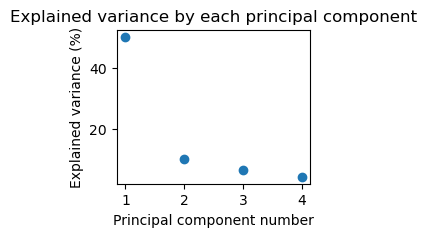

The first 4 principal components explain 71.43% variance.
All principal components used for this analysis (4 components) together explain 71.43% variance.


In [34]:
#PCA with 4 componets
(spectra_transformed_17_4_4,variances_17_4_4,components_17_4_4)=[x.copy() for x in perform_PCA(spectra_PCA_17_4,4)]

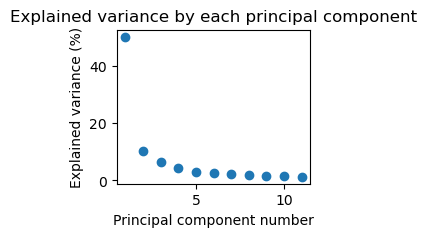

The first 4 principal components explain 71.43% variance.
All principal components used for this analysis (11 components) together explain 85.06% variance.


In [35]:
#PCA with 11 componets
(spectra_transformed_17_4_11,variances_17_4_11,components_17_4_11)=[x.copy() for x in perform_PCA(spectra_PCA_17_4,11)]

#### 17.10 loop library

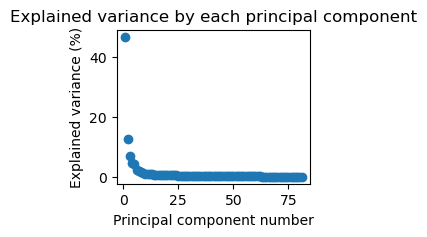

The first 4 principal components explain 70.93% variance.
The first 21 principal components explain 90.22% variance.


In [36]:
#PCA without limiting the number of principal components
(spectra_transformed_17_10_0,variances_17_10_0,components_17_10_0)=[x.copy() for x in perform_PCA(spectra_PCA_17_10,0)]

In [37]:
variances_17_10_0[:21]

array([0.46827883, 0.12727777, 0.068338  , 0.04538697, 0.04100342,
       0.02297669, 0.01861635, 0.0150536 , 0.01136127, 0.00969206,
       0.00916892, 0.00879351, 0.00793768, 0.00738032, 0.00733719,
       0.00656088, 0.00610889, 0.00567857, 0.00532517, 0.00512883,
       0.00484015])

The first 4 principal components explain together slightly over 70%, but the fourth and fifth principal component explain almost the same amount of varibility of the dataset and variances drop after that, so the first number of PCs, which I will use, is 5. I think that 21 principal components is too much, so the next number, which I will try, is 10.

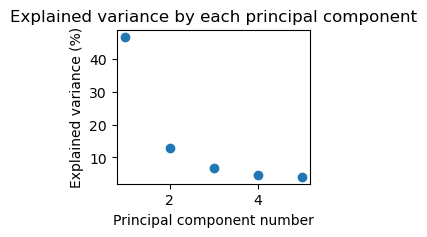

The first 4 principal components explain 70.93% variance.
All principal components used for this analysis (5 components) together explain 75.03% variance.


In [38]:
#PCA with 5 components
(spectra_transformed_17_10_5,variances_17_10_5,components_17_10_5)=[x.copy() for x in perform_PCA(spectra_PCA_17_10,5)]

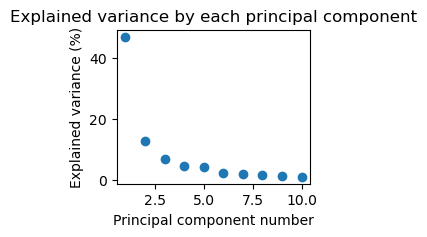

The first 4 principal components explain 70.93% variance.
All principal components used for this analysis (10 components) together explain 82.80% variance.


In [39]:
#PCA with 10 components
(spectra_transformed_17_10_10,variances_17_10_10,components_17_10_10)=[x.copy() for x in perform_PCA(spectra_PCA_17_10,10)]

### Putting all variables into one dataframe

For the clustering, I will use data from three dataframes: sequence varibles from dataframe sequence_variables, biochemical activities from dataframe activities and NMR spectra from dataframe with transformed spectra. I will create two dataframes for each studied dataset (whole dataset, 17.3 library, 17.4 library, and 17.10 library). When putting all data together, I will not be explicitly checking that the order of samples is the same in all merged dataframes, because I know that the used sources (and also the publically avaliable ones) all have the same order of samples, but this is something that would need an improvement if this approach would to be developed beyond POC.

In [40]:
#Whole dataset
#Creating a dataframe with 6 spectral variables
all_variables_6=pd.concat([sequence_variables,activities,spectra_transformed_6], axis=1)
all_variables_6=all_variables_6.drop('sample_name',axis=1)
all_variables_6=all_variables_6.drop('sample name',axis=1)

#Creating a dataframe with 20 spectral variables
all_variables_20=pd.concat([sequence_variables,activities,spectra_transformed_20], axis=1)
all_variables_20=all_variables_20.drop('sample_name',axis=1)
all_variables_20=all_variables_20.drop('sample name',axis=1)

In [41]:
#Tetrad library
#Creating a dataframe with 9 spectral variables
all_variables_tetrad_9=pd.concat([sequence_variables_tetrad,activities_tetrad,spectra_transformed_tetrad_9], axis=1)
all_variables_tetrad_9=all_variables_tetrad_9.drop('sample_name',axis=1)
all_variables_tetrad_9=all_variables_tetrad_9.drop('sample name',axis=1)

#Creating a dataframe with 20 spectral variables
all_variables_tetrad_20=pd.concat([sequence_variables_tetrad,activities_tetrad,spectra_transformed_tetrad_20], axis=1)
all_variables_tetrad_20=all_variables_tetrad_20.drop('sample_name',axis=1)
all_variables_tetrad_20=all_variables_tetrad_20.drop('sample name',axis=1)

In [42]:
#17.3 library
#Creating a dataframe with 4 spectral variables
all_variables_17_3_4=pd.concat([sequence_variables_17_3,activities_17_3,spectra_transformed_17_3_4], axis=1)
all_variables_17_3_4=all_variables_17_3_4.drop('sample_name',axis=1)
all_variables_17_3_4=all_variables_17_3_4.drop('sample name',axis=1)

#Creating a dataframe with 10 spectral variables
all_variables_17_3_11=pd.concat([sequence_variables_17_3,activities_17_3,spectra_transformed_17_3_11], axis=1)
all_variables_17_3_11=all_variables_17_3_11.drop('sample_name',axis=1)
all_variables_17_3_11=all_variables_17_3_11.drop('sample name',axis=1)

In [43]:
#17.4 library
#Creating a dataframe with 4 spectral variables
all_variables_17_4_4=pd.concat([sequence_variables_17_4,activities_17_4,spectra_transformed_17_4_4], axis=1)
all_variables_17_4_4=all_variables_17_4_4.drop('sample_name',axis=1)
all_variables_17_4_4=all_variables_17_4_4.drop('sample name',axis=1)

#Creating a dataframe with 10 spectral variables
all_variables_17_4_11=pd.concat([sequence_variables_17_4,activities_17_4,spectra_transformed_17_4_11], axis=1)
all_variables_17_4_11=all_variables_17_4_11.drop('sample_name',axis=1)
all_variables_17_4_11=all_variables_17_4_11.drop('sample name',axis=1)

In [44]:
#17.10 library
#Creating a dataframe with 5 spectral variables
all_variables_17_10_5=pd.concat([sequence_variables_17_10,activities_17_10,spectra_transformed_17_10_5], axis=1)
all_variables_17_10_5=all_variables_17_10_5.drop('sample_name',axis=1)
all_variables_17_10_5=all_variables_17_10_5.drop('sample name',axis=1)

#Creating a dataframe with 10 spectral variables
all_variables_17_10_10=pd.concat([sequence_variables_17_10,activities_17_10,spectra_transformed_17_10_10], axis=1)
all_variables_17_10_10=all_variables_17_10_10.drop('sample_name',axis=1)
all_variables_17_10_10=all_variables_17_10_10.drop('sample name',axis=1)

### Clustering

For clustering, I will use HDBSCAN, since there will be classes with a vastly different size and some classes will differ significantly from the others, while other classes will be close to each other, so HDBSCAN should be a good choice for this task. If I decide to develop this approach beyond POC, I might consider testing more clustering algorithms.

In [45]:
#Whole dataset
results_all_data=sequence_variables[['sample_name']].copy()
results_all_data['Cluster_6']=perform_clustering(all_variables_6)
results_all_data['Cluster_20']=perform_clustering(all_variables_20)
results_all_data['Comparison']=results_comparison['Class'].copy()

In [46]:
#Tetrad library dataset
results_tetrad=sequence_variables_tetrad[['sample_name']].copy()
results_tetrad['Cluster_9']=perform_clustering(all_variables_tetrad_9)
results_tetrad['Cluster_20']=perform_clustering(all_variables_tetrad_20)
results_tetrad['Comparison']=results_comparison_tetrad['Class'].copy()

In [47]:
#17.3 library dataset
results_17_3=sequence_variables_17_3[['sample_name']].copy()
results_17_3['Cluster_4']=perform_clustering(all_variables_17_3_4)
results_17_3['Cluster_11']=perform_clustering(all_variables_17_3_11)
results_17_3['Comparison']=results_comparison_17_3['Class'].copy()

In [48]:
#17.4 library dataset
results_17_4=sequence_variables_17_4[['sample_name']].copy()
results_17_4['Cluster_4']=perform_clustering(all_variables_17_4_4)
results_17_4['Cluster_11']=perform_clustering(all_variables_17_4_11)
results_17_4['Comparison']=results_comparison_17_4['Class'].copy()

In [49]:
#17.10 library dataset
results_17_10=sequence_variables_17_10[['sample_name']].copy()
results_17_10['Cluster_4']=perform_clustering(all_variables_17_10_5)
results_17_10['Cluster_11']=perform_clustering(all_variables_17_10_10)
results_17_10['Comparison']=results_comparison_17_10['Class'].copy()

## Analysis of results

I will look at distribution of sequences into clusters for all analyzed datasets and I will compare it with results obtained in previous studies.

### Whole dataset

In [50]:
results_all_data['Cluster_6'].value_counts()

Cluster_6
 1    245
 0    224
-1     27
Name: count, dtype: int64

In [51]:
results_all_data['Cluster_20'].value_counts()

Cluster_20
-1    310
 5     68
 8     30
 4     30
 7     15
 0     12
 3     11
 6      8
 1      7
 2      5
Name: count, dtype: int64

In [52]:
results_all_data['Comparison'].value_counts()

Comparison
No G4 signals            154
17.63, 17.63a, 17.63d     76
17.4s26                   53
17.4, 17.4a, 17.4c        20
17.118                    18
17.3, 17.3b, 17.3d        18
17.3, 17.3d               18
17.3, 17.3c               18
17.3, 17.3a               18
17.36                     16
17.4, 17.4a, 17.4d        11
17.63, 17.63a, 17.63c     10
17.63, 17.63b, 17.63d      9
17.3, 17.3a, 17.3b         9
17.154                     8
17.28                      8
17.4 + 17.4s26             8
17.180                     7
No clear pattern           7
17.49                      6
17.4, 17.4b, 17.4c         3
17.109                     1
Name: count, dtype: int64

Now, I will look at each cluster in more detail and I will try to determine, if there is a connection with a previously determined classes or not.

In [53]:
cluster_all_data_6_1=results_all_data[results_all_data['Cluster_6']==1]
cluster_all_data_6_1['Comparison'].value_counts()

Comparison
17.63, 17.63a, 17.63d    67
17.4s26                  53
17.4, 17.4a, 17.4c       20
17.3, 17.3a              18
17.3, 17.3c              18
17.3, 17.3d              18
17.3, 17.3b, 17.3d       17
17.4, 17.4a, 17.4d       10
17.3, 17.3a, 17.3b        8
17.4 + 17.4s26            8
17.63, 17.63a, 17.63c     7
17.4, 17.4b, 17.4c        1
Name: count, dtype: int64

In [54]:
cluster_all_data_6_0=results_all_data[results_all_data['Cluster_6']==0]
cluster_all_data_6_0['Comparison'].value_counts()

Comparison
No G4 signals            154
17.118                    15
17.36                     13
17.28                      8
No clear pattern           7
17.180                     7
17.154                     7
17.63, 17.63a, 17.63d      5
17.49                      5
17.63, 17.63b, 17.63d      2
17.109                     1
Name: count, dtype: int64

In [55]:
cluster_all_data_6_noise=results_all_data[results_all_data['Cluster_6']==-1]
cluster_all_data_6_noise['Comparison'].value_counts()

Comparison
17.63, 17.63b, 17.63d    7
17.63, 17.63a, 17.63d    4
17.36                    3
17.118                   3
17.63, 17.63a, 17.63c    3
17.4, 17.4b, 17.4c       2
17.49                    1
17.154                   1
17.3, 17.3a, 17.3b       1
17.3, 17.3b, 17.3d       1
17.4, 17.4a, 17.4d       1
Name: count, dtype: int64

In [56]:
cluster_all_data_20_5=results_all_data[results_all_data['Cluster_20']==5]
cluster_all_data_20_5['Comparison'].value_counts()

Comparison
17.63, 17.63a, 17.63d    64
17.63, 17.63a, 17.63c     4
Name: count, dtype: int64

In [57]:
cluster_all_data_20_7=results_all_data[results_all_data['Cluster_20']==7]
cluster_all_data_20_7['Comparison'].value_counts()

Comparison
17.3, 17.3b, 17.3d    15
Name: count, dtype: int64

In [58]:
cluster_all_data_20_4=results_all_data[results_all_data['Cluster_20']==4]
cluster_all_data_20_4['Comparison'].value_counts()

Comparison
17.4s26               25
17.4 + 17.4s26         4
17.4, 17.4a, 17.4d     1
Name: count, dtype: int64

In [59]:
cluster_all_data_20_8=results_all_data[results_all_data['Cluster_20']==8]
cluster_all_data_20_8['Comparison'].value_counts()

Comparison
17.3, 17.3d    15
17.3, 17.3c    14
17.3, 17.3a     1
Name: count, dtype: int64

In [60]:
cluster_all_data_20_3=results_all_data[results_all_data['Cluster_20']==3]
cluster_all_data_20_3['Comparison'].value_counts()

Comparison
17.4, 17.4a, 17.4c    10
17.4, 17.4b, 17.4c     1
Name: count, dtype: int64

In [61]:
cluster_all_data_20_1=results_all_data[results_all_data['Cluster_20']==1]
cluster_all_data_20_1['Comparison'].value_counts()

Comparison
17.118    6
17.154    1
Name: count, dtype: int64

In [62]:
cluster_all_data_20_2=results_all_data[results_all_data['Cluster_20']==2]
cluster_all_data_20_2['Comparison'].value_counts()

Comparison
17.28    5
Name: count, dtype: int64

In [63]:
cluster_all_data_20_0=results_all_data[results_all_data['Cluster_20']==0]
cluster_all_data_20_0['Comparison'].value_counts()

Comparison
No G4 signals    12
Name: count, dtype: int64

In [64]:
cluster_all_data_20_noise=results_all_data[results_all_data['Cluster_20']==-1]
cluster_all_data_20_noise['Comparison'].value_counts()

Comparison
No G4 signals            142
17.4s26                   28
17.36                     16
17.63, 17.63a, 17.63d     12
17.118                    12
17.3, 17.3a               11
17.4, 17.4a, 17.4d        10
17.4, 17.4a, 17.4c        10
17.63, 17.63b, 17.63d      9
17.180                     7
No clear pattern           7
17.154                     7
17.3, 17.3a, 17.3b         7
17.49                      6
17.63, 17.63a, 17.63c      6
17.4 + 17.4s26             4
17.3, 17.3c                4
17.3, 17.3b, 17.3d         3
17.3, 17.3d                3
17.28                      3
17.4, 17.4b, 17.4c         2
17.109                     1
Name: count, dtype: int64

In [65]:
cluster_all_data_20_6=results_all_data[results_all_data['Cluster_20']==6]
cluster_all_data_20_6['Comparison'].value_counts()

Comparison
17.3, 17.3a           6
17.3, 17.3a, 17.3b    2
Name: count, dtype: int64

When 6 principal components are used to represent NMR spectra, sequences are sorted into two clusters, cluster 1 contains active sequences with above-background values of at least some activities and strong signal above background in studied region of NMR spectra, often with significant patterns, while cluster one contains almost only sequences with low activities and low to no signal above backround in studied region of NMR spectra (these observations can be made based on comparison with figures at the beginning). This is the strongest pattern in analyzed dataset, so the fact, that our aproach was able to detect it with only 6 variables representing each NMR spectrum, is showing that this type of analysis works.

When 20 principal components are used, multiple previously identified classes emerge as individual clusters. Specifically, we can see Classes 17.63, 17.3 (with a hint of sorting into subclasses, but not a perfect one), 17.4s26, 17.4, 17.118, and 17.28. However, majority of the dataset is in the noise cluster, so tuning of parameters or resorting of the noise cluster by hand is necessary.

Taken together, it is clear that even when Classes differ significantly based on their biochemical activities, it is necessary to include enough spectral information (enough high number of principal components) to diferentiate them.

### Tetrad library

In [66]:
results_tetrad['Cluster_9'].value_counts()

Cluster_9
 0    237
 1     14
-1      5
Name: count, dtype: int64

In [67]:
results_tetrad['Cluster_20'].value_counts()

Cluster_20
 0    199
-1     43
 1     14
Name: count, dtype: int64

In [68]:
results_tetrad['Comparison'].value_counts()

Comparison
No G4 signals            154
17.118                    18
17.36                     16
17.4, 17.4a, 17.4c        12
17.63, 17.63b, 17.63d      9
17.28                      8
17.154                     8
No clear pattern           7
17.180                     7
17.63, 17.63a, 17.63d      6
17.49                      6
17.4, 17.4b, 17.4c         3
17.3, 17.3a                1
17.109                     1
Name: count, dtype: int64

In [69]:
cluster_tetrad_9_1=results_tetrad[results_tetrad['Cluster_9']==1]
cluster_tetrad_9_1['Comparison'].value_counts()

Comparison
17.4, 17.4a, 17.4c    12
17.4, 17.4b, 17.4c     2
Name: count, dtype: int64

In [70]:
cluster_tetrad_9_0=results_tetrad[results_tetrad['Cluster_9']==0]
cluster_tetrad_9_0['Comparison'].value_counts()

Comparison
No G4 signals            154
17.118                    18
17.36                     16
17.28                      8
17.154                     8
No clear pattern           7
17.180                     7
17.49                      6
17.63, 17.63b, 17.63d      6
17.63, 17.63a, 17.63d      5
17.4, 17.4b, 17.4c         1
17.109                     1
Name: count, dtype: int64

In [71]:
cluster_tetrad_9_noise=results_tetrad[results_tetrad['Cluster_9']==-1]
cluster_tetrad_9_noise['Comparison'].value_counts()

Comparison
17.63, 17.63b, 17.63d    3
17.3, 17.3a              1
17.63, 17.63a, 17.63d    1
Name: count, dtype: int64

In [72]:
cluster_tetrad_20_1=results_tetrad[results_tetrad['Cluster_20']==1]
cluster_tetrad_20_1['Comparison'].value_counts()

Comparison
17.4, 17.4a, 17.4c    12
17.4, 17.4b, 17.4c     2
Name: count, dtype: int64

In [73]:
cluster_tetrad_20_0=results_tetrad[results_tetrad['Cluster_20']==0]
cluster_tetrad_20_0['Comparison'].value_counts()

Comparison
No G4 signals            120
17.118                    18
17.36                     16
17.28                      8
17.154                     8
No clear pattern           7
17.180                     6
17.63, 17.63a, 17.63d      5
17.63, 17.63b, 17.63d      5
17.49                      4
17.4, 17.4b, 17.4c         1
17.109                     1
Name: count, dtype: int64

In [74]:
cluster_tetrad_20_noise=results_tetrad[results_tetrad['Cluster_20']==-1]
cluster_tetrad_20_noise['Comparison'].value_counts()

Comparison
No G4 signals            34
17.63, 17.63b, 17.63d     4
17.49                     2
17.3, 17.3a               1
17.63, 17.63a, 17.63d     1
17.180                    1
Name: count, dtype: int64

Clustering of the tetrad library was able to identify the 17.4 Class, but it failed to identify any other cluster of sequences, which is highly surprising, because there are other significant groups - for example inactive sequences with no signals in NMR spectrum, so further optimization of the used algorithm might be appropriate.

### 17.3 loop library

In [75]:
results_17_3['Cluster_4'].value_counts()

Cluster_4
-1    51
 1    19
 0    11
Name: count, dtype: int64

In [76]:
results_17_3['Cluster_11'].value_counts()

Cluster_11
-1    55
 1    17
 0     9
Name: count, dtype: int64

In [77]:
results_17_3['Comparison'].value_counts()

Comparison
17.3, 17.3a           18
17.3, 17.3c           18
17.3, 17.3d           18
17.3, 17.3b, 17.3d    18
17.3, 17.3a, 17.3b     9
Name: count, dtype: int64

In [78]:
cluster_17_3_4_1=results_17_3[results_17_3['Cluster_4']==1]
cluster_17_3_4_1['Comparison'].value_counts()

Comparison
17.3, 17.3d    11
17.3, 17.3c     8
Name: count, dtype: int64

In [79]:
cluster_17_3_4_0=results_17_3[results_17_3['Cluster_4']==0]
cluster_17_3_4_0['Comparison'].value_counts()

Comparison
17.3, 17.3b, 17.3d    11
Name: count, dtype: int64

In [80]:
cluster_17_3_4_noise=results_17_3[results_17_3['Cluster_4']==-1]
cluster_17_3_4_noise['Comparison'].value_counts()

Comparison
17.3, 17.3a           18
17.3, 17.3c           10
17.3, 17.3a, 17.3b     9
17.3, 17.3d            7
17.3, 17.3b, 17.3d     7
Name: count, dtype: int64

In [81]:
cluster_17_3_11_1=results_17_3[results_17_3['Cluster_11']==1]
cluster_17_3_11_1['Comparison'].value_counts()

Comparison
17.3, 17.3b, 17.3d    11
17.3, 17.3d            6
Name: count, dtype: int64

In [82]:
cluster_17_3_11_0=results_17_3[results_17_3['Cluster_11']==0]
cluster_17_3_11_0['Comparison'].value_counts()

Comparison
17.3, 17.3c    9
Name: count, dtype: int64

In [83]:
cluster_17_3_11_noise=results_17_3[results_17_3['Cluster_11']==-1]
cluster_17_3_11_noise['Comparison'].value_counts()

Comparison
17.3, 17.3a           18
17.3, 17.3d           12
17.3, 17.3c            9
17.3, 17.3a, 17.3b     9
17.3, 17.3b, 17.3d     7
Name: count, dtype: int64

Subclasses identified in previous studies in 17.3 loop library are defined purely based on spectral features and it is clear, that differences between them cannot be distinguished, when 'only' 90% of spectral information is retained, which is surprising.

### 17.4 loop library

In [84]:
results_17_4['Cluster_4'].value_counts()

Cluster_4
-1    81
Name: count, dtype: int64

In [85]:
results_17_4['Cluster_11'].value_counts()

Cluster_11
-1    81
Name: count, dtype: int64

In [86]:
results_17_4['Comparison'].value_counts()

Comparison
17.4s26               53
17.4, 17.4a, 17.4d    11
17.4, 17.4a, 17.4c     9
17.4 + 17.4s26         8
Name: count, dtype: int64

Clustering of this dataset failed, which might be explained by the fact, that the two major classes in this dataset are overlapping, which is challenging for clustering.

### 17.10 loop library

In [87]:
results_17_10['Cluster_4'].value_counts()

Cluster_4
-1    81
Name: count, dtype: int64

In [88]:
results_17_10['Cluster_11'].value_counts()

Cluster_11
-1    81
Name: count, dtype: int64

In [89]:
results_17_10['Comparison'].value_counts()

Comparison
17.63, 17.63a, 17.63d    71
17.63, 17.63a, 17.63c    10
Name: count, dtype: int64

17.10 loop library contains data with small variability, so I would be surprised, if any meaningfull clustering would be visible without a significant optimization.

## Conclusion

This analysis is a proof of concept testing whether datasets of vastly different dimensionality can be integrated and jointly analyzed. The test case used here combines high-dimensional NMR spectra with low-dimensional biochemical activities. The results demonstrate that reducing the dimensionality of part of a dataset using PCA, followed by clustering with HDBSCAN, is a viable approach. 

However, they also show that achieving optimal performance will require further optimization—for example, using more principal components than considered here, as my choices were likely too small, fine-tuning HDBSCAN parameters, and potentially exploring other clustering and dimensionality-reduction algorithms. 

Finally, the analysis of results was intentionally brief, focusing on connections to previously published findings. Any work beyond this proof of concept would require a more detailed and systematic examination.

#### Acknowledgements
Portions of the text in this notebook were edited with assistance from OpenAI's ChatGPT, subsequently reviewed and revised by the author. ChatGPT was also consulted for programming related questions and clarifications, however all code was written, tested, and validated by the author.